In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import ticker
import math
from pathlib import Path
import string
import matplotlib.colors as colours
import matplotlib.patheffects as pe


plt.rcParams["font.family"] = "Times New Roman"
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [2]:
cmax_vals = [4.7, 4.8, 4.9, 5., 5.1] #values of c_max
# rImm_vals = [r for r in np.arange(18., 23.)]
# rImm_vals[0] = 18.5
# rImm_vals = rImm_vals[::-1]
rImm_vals = [19., 19.5, 20., 20.5, 21.]
cmax_session2_string = "session-2"
rImm_session2_string = "-session2"

g_max_vals = [0.073, 0.078, 0.083, 0.088, 0.093]
K_vals = [500, 525, 538, 550, 562]#, 575] #[350, 450, 550, 650, 750]
det_ratio_vals = [dr for dr in np.arange(0.2, 0.24+0.01, 0.01)]
pc_res_vals = [14., 15., 16.]
N_thresh_vals = [0.7, 0.73, 0.74, 0.75, 0.76,]

In [3]:
max_g_rate = 0.083

In [4]:
def getListOfDataFramesForModelParam(directory_name, variable_name, pc_res, variable_vals, n_sig_figs=2, session2_string="blanko"):
    '''
    gets a list containing the dataframes for each ttf simulation as a function of a model parameter for a specified % resistant
    directory name is the directory containing the data, depends on the variable of choice.
    variable name 
    session2_string is slightly different between the parameters, so need to provide this too
    '''
    
    df_list = []
    
    for v in variable_vals:
        
        df1 = pd.read_csv(directory_name+"/timeToFailure-"+str(pc_res)+"_pc_res-"+variable_name+"="+f"{v:.{n_sig_figs}f}"+".csv")
        df = df1
        #session 2
        if Path(directory_name+"/timeToFailure-"+str(pc_res)+"_pc_res-"+variable_name+"="+f"{v:.{n_sig_figs}f}"+session2_string+".csv").exists():
            
            df2 = pd.read_csv(directory_name+"/timeToFailure-"+str(pc_res)+"_pc_res-"+variable_name+"="+f"{v:.{n_sig_figs}f}"+session2_string+".csv")

            df = pd.concat([df1, df2], ignore_index=True)
        
        df_list.append(df)
        
    return df_list

In [5]:
def survival_probability(ttf_data):
    '''takes in a dataframe and works out the survival probability as a function of time'''
    histo, bin_edges = np.histogram(ttf_data["failure_time"], bins=100)
    n_vals = len(ttf_data) #get number of runs
    survival_probs = (n_vals-np.cumsum(histo[1:]))/n_vals #get the survival probs (ignoring the 0 bin)
    survival_probs = np.append(1., survival_probs) #add the initial value of 1. for t = 0
    errs = (survival_probs*(1. - survival_probs))/np.sqrt(n_vals)
    #print(n_vals)
    #print(errs)
    #ignore the final value in surv_probs due to exit time being t_max by default
    return bin_edges[:-2], survival_probs[:-1], errs[:-1]

In [6]:
def plot_survival_probs(ttf_df_list, c_vals):
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    for ttf_d, c_val in zip(ttf_df_list, c_vals):
        
        t, surv_prob, errs = survival_probability(ttf_d)
        ax.errorbar(t[:], surv_prob[:], yerr=errs[:], lw=2.2, label =  "$c_{\max} = $"+str(c_val))
    
    
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    ax.set_ylim(0, 1.01)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize="large")
    plt.show()
    
#plot_survival_probs()

In [7]:
ttf_14pcres_vs_cmax = getListOfDataFramesForModelParam("time_to_failure_data_vs_cmax", "c_max", 14, cmax_vals, session2_string=cmax_session2_string)
ttf_15pcres_vs_cmax = getListOfDataFramesForModelParam("time_to_failure_data_vs_cmax", "c_max", 15, cmax_vals, session2_string=cmax_session2_string)
ttf_16pcres_vs_cmax = getListOfDataFramesForModelParam("time_to_failure_data_vs_cmax", "c_max", 16, cmax_vals, session2_string=cmax_session2_string)

In [8]:
ttf_14pcres_vs_rImm = getListOfDataFramesForModelParam("time_to_failure_vs_r_imm", "r_imm", 14, rImm_vals, session2_string=rImm_session2_string)
# ttf_15pcres_vs_rImm = getListOfDataFramesForModelParam("time_to_failure_vs_r_imm", "r_imm", 15, rImm_vals, session2_string=rImm_session2_string)
# ttf_16pcres_vs_rImm = getListOfDataFramesForModelParam("time_to_failure_vs_r_imm", "r_imm", 16, rImm_vals, session2_string=rImm_session2_string)

In [9]:
ttf_vs_pc_res = [ttf_14pcres_vs_cmax[-2], ttf_15pcres_vs_cmax[-2], ttf_16pcres_vs_cmax[-2]] # get the different % resistant runs. [-2] is the index of the default c_max vals

In [10]:
ttf_14pcres_vs_g_max = getListOfDataFramesForModelParam("time_to_failure_vs_g_max", "g_max", 14, g_max_vals, n_sig_figs=3)
ttf_14pcres_vs_K = getListOfDataFramesForModelParam("time_to_failure_vs_K", "K", 14, K_vals, n_sig_figs=3)
ttf_14pcres_vs_det_ratio = getListOfDataFramesForModelParam("time_to_failure_vs_deterioration_ratio", "deterioration_ratio", 14, det_ratio_vals, n_sig_figs=3)
ttf_14pcres_vs_N_thresh = getListOfDataFramesForModelParam("time_to_failure_vs_biofilm_threshold", "biofilm_threshold", 14, N_thresh_vals, n_sig_figs=3)

In [11]:
def fit_and_plot_survival_slope(ttf_df_list, cmax_vals):
    '''this function takes in the survival probability data and fits an exponential decay to it.  We can then extract the slope and plot this vs % resistant
    returns a list of tuples.  each tuple contains the % resistance of a population and its associated characteristic failure time tau'''
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        return a*np.exp(-b*x) #+ c
    
        
    cmax_tau_and_err = [] #this is the list that the cmax vals, exponential slopes and the associated fit error will be saved to
    
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, c_max in zip(ttf_df_list, cmax_vals):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability(ttf)
        
        popt, pcov = curve_fit(func, t[0:], surv_prob[0:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        fit_errs = np.sqrt(np.diag(pcov))
        print(popt)
        print(fit_errs)
        print()
        
        cmax_tau_and_err.append((c_max, popt[1], fit_errs[1]))
        
        color=next(ax._get_lines.prop_cycler)['color']
        ax.plot(t, surv_prob, color=color, lw=2.2, label=str(c_max))
        ax.plot(t, func(t, *popt), color=color, ls='--', lw=2.2)#, label=str(pc_r)+'% resistant (fit)')
        
        
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize="large", title="c$_{\max}$")
    plt.rcParams['legend.title_fontsize'] = '14'
    #plt.savefig('plots/fitted_surv_probs.pdf')
    plt.show()
    
    return cmax_tau_and_err

In [12]:
def plot_characteristic_failure_rate(cmax_and_tau):
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    cmax, tau, tau_err = zip(*cmax_and_tau) #transposes the list to extract the slopes
    tau_err_percent = [t_e/t for t, t_e in zip(tau, tau_err)] #find percent error to better manage reciprocals
    
    tau_scaled = [1./(t*24.*365.) for t in tau] #converts from per hour to time in years
    tau_err_scaled = [t*t_e_percent for t, t_e_percent in zip(tau_scaled, tau_err_percent)]
    print(tau)
    print(tau_err)
    print(tau_err_percent)
    print(tau_err_scaled)
    
    tau_err_analytic = [(abs(1./t)*t_err/(abs(t)))*(1./(24.*365)) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    print(tau_err_analytic)
    
    
    ax.errorbar(cmax, tau_scaled, yerr=tau_err_scaled, lw=2.2)
    ax.plot(cmax, tau_scaled, marker='h', ms=12, lw=2.2)
    
    ax.set_title('Failure characteristic vs c$_{\max}$', fontsize=titleSize)
    ax.set_xlabel('c$_{\max}$', fontsize=labelSize)
    ax.set_ylabel('time to failure (years)', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    ax.semilogy()
    #plt.savefig('plots/failure_char_vs_pcres.pdf')
    plt.show()

In [13]:
def plot_fitSlopes_and_failRate(ttf_df_list, variable_vals, variable_name, filename, letter_in_top=True, n_sig_figs=2, rescale=False, units=None):
    '''
    plots a 2x1 plot of the fitted survival probabilities and the time to failure vs c_max
    
    rescale is to convert r_det/g_max to just r_det, by multiplying each r_det by g_max

    '''
    
    fig, axes = plt.subplots(1, 2, dpi=220)
    fig.set_size_inches(6,3)
    titleSize = 22
    labelSize = 20
    numbersize = 16
    legendsize = 16
    IDsize=14
    letterSize=18
    nbins = 32
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    
    if rescale: variable_vals = [v*max_g_rate for v in variable_vals]
    
    variable_tau_and_err = [] #this is the list that the variable (eg c_max or rImm) vals, exponential slopes and the associated fit error will be saved to
    
    # fit curves to the survival probability data
    ######################################
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        #return a*np.exp(-b*x) #+ c
        return np.exp(-b*x)
        #return a*x + b
        
    # remove the white part of the colourmap
    min_val, max_val = 0.22,0.95
    n = 256
    orig_cmap = plt.cm.plasma_r
    colors = orig_cmap(np.linspace(min_val, max_val, n))
    c_map = colours.LinearSegmentedColormap.from_list("mycmap", colors)
    line_colours = c_map(np.linspace(0, 1, len(variable_vals)))
        
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, var_val, line_colour in zip(ttf_df_list, variable_vals, line_colours):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability(ttf)
        t_scaled = np.array([t_val/(24.*365.) for t_val in t])
        
        popt, pcov = curve_fit(func, t_scaled[0:], surv_prob[0:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        fit_errs = np.sqrt(np.diag(pcov))
        
        variable_tau_and_err.append((var_val, popt[1], fit_errs[1]))
        
        #color=next(axes[0]._get_lines.prop_cycler)['color']
        color=line_colour
        axes[0].plot(t_scaled, surv_prob, color=color, lw=1.4, label=f"{float((var_val)):.{n_sig_figs}}")
        axes[0].plot(t_scaled, func(t_scaled, *popt), color=color, ls='--', lw=2.2)#, label=str(pc_r)+'% resistant (fit)')
        
    axes[0].set_title('$p_s$ vs $t$', fontsize=titleSize)
    axes[0].set_xlabel('$t$ (years)', fontsize=labelSize, labelpad=-1)
    axes[0].set_ylabel('$p_s$', fontsize=labelSize, labelpad=0)
    axes[0].xaxis.set_tick_params(labelsize=numbersize)
    axes[0].yaxis.set_tick_params(labelsize=numbersize)
    handles, labels = axes[0].get_legend_handles_labels()
    plt.rcParams['legend.title_fontsize'] = '14'
    #axes[0].legend(handles[::-1], labels[::-1], fontsize="12", title=variable_name, framealpha=0.5)
    axes[0].legend(handles[::-1], labels[::-1], frameon=True, loc=(0.02,0.02), title=variable_name,
                   handletextpad=0.4, framealpha=0.5, fontsize=12, borderpad=0.1, handlelength=1, labelspacing=0.2, edgecolor='none')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].yaxis.set_major_locator(plt.MaxNLocator(2))
    
    if letter_in_top: axes[0].text(0.96, 0.925, "(a)", transform=axes[0].transAxes, fontsize=letterSize)
    else: axes[0].text(0.96, 0.03, "(a)", transform=axes[0].transAxes, fontsize=letterSize)
        
    #plt.rcParams['legend.title_fontsize'] = '10'    
    
    
    
    
    
    
    
    var_val, tau, tau_err = zip(*variable_tau_and_err) #transposes the list to extract the slopes
    tau_err_percent = [t_e/t for t, t_e in zip(tau, tau_err)] #find percent error to better manage reciprocals
    
    tau_scaled = [1./(t*24.*365.) for t in tau] #converts from per hour to time in years
    tau_err_scaled = [t*t_e_percent for t, t_e_percent in zip(tau_scaled, tau_err_percent)]
#     print(tau)
#     print(tau_err)
#     print(tau_err_percent)
#     print(tau_err_scaled)
    
    ttf = [1./tau_val for tau_val in tau]
    #print(ttf)
    tau_err_analytic = [(abs(1./t)*t_err/(abs(t)))*(1./(24.*365)) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    tau_err_analytic_v2 = [(abs(1./t)*t_err/(abs(t))) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    #print(tau_err_analytic_v2)
    
    color=next(axes[1]._get_lines.prop_cycler)['color']
#     axes[1].errorbar(var_val, ttf, yerr=tau_err_analytic_v2, lw=2.2, color=color)
#     axes[1].plot(var_val, ttf, marker='h', ms=6, lw=2.2, color=color)
    
    p = np.array(np.polyfit(var_val, np.log(ttf), 1))
    axes[1].plot(np.array(var_val), np.exp(p[0] * np.array(var_val) + p[1]), 'k--', lw=2., zorder=-20)
    axes[1].scatter(var_val, ttf, marker='h', s=40, color=line_colours)
    
    axes[1].set_title('$t_f$ vs '+variable_name, fontsize=titleSize)
    axes[1].set_xlabel(variable_name, fontsize=labelSize, labelpad=-1)
    axes[1].set_ylabel('$t_f$ (years)', fontsize=labelSize, labelpad=-3)
    axes[1].xaxis.set_tick_params(labelsize=numbersize)
    axes[1].yaxis.set_tick_params(labelsize=numbersize)
    axes[1].semilogy()
    
    if letter_in_top: axes[1].text(0.01, 0.925, "(b)", transform=axes[1].transAxes, fontsize=letterSize)
    else: axes[1].text(0.865, 0.925, "(b)", transform=axes[1].transAxes, fontsize=letterSize)
#     axes[1].tick_params(axis='both', which='major', pad=1)
    
    plt.subplots_adjust(wspace=0.3)
    plt.savefig("time_to_failure_plots/"+filename+".pdf", bbox_inches="tight")
    if variable_name == "$c_{max}$": plt.savefig("ms_paper_plots/"+filename+".pdf", bbox_inches='tight', dpi=330)
    plt.show()
    
    
    # write the processed ttf data to file
    #friendly_variable_name = filename.split("_")[-1]
    friendly_variable_name = variable_name.replace("$", "").replace("{", "").replace("}", "").replace("% ", "pc_").split("/")[0]
    #print(friendly_variable_name)
    ttf_df = pd.DataFrame({'param_val': var_val, 'ttf':ttf})
    ttf_df.to_csv(f'ttf_processed_data/ttf_vs_{friendly_variable_name}.csv', index=False)
    
    
    
    
    return var_val, ttf, variable_name, units # return the parameter values of interest, times to failure vs the parameter of interest, x-label for param of interest, units of param of interest


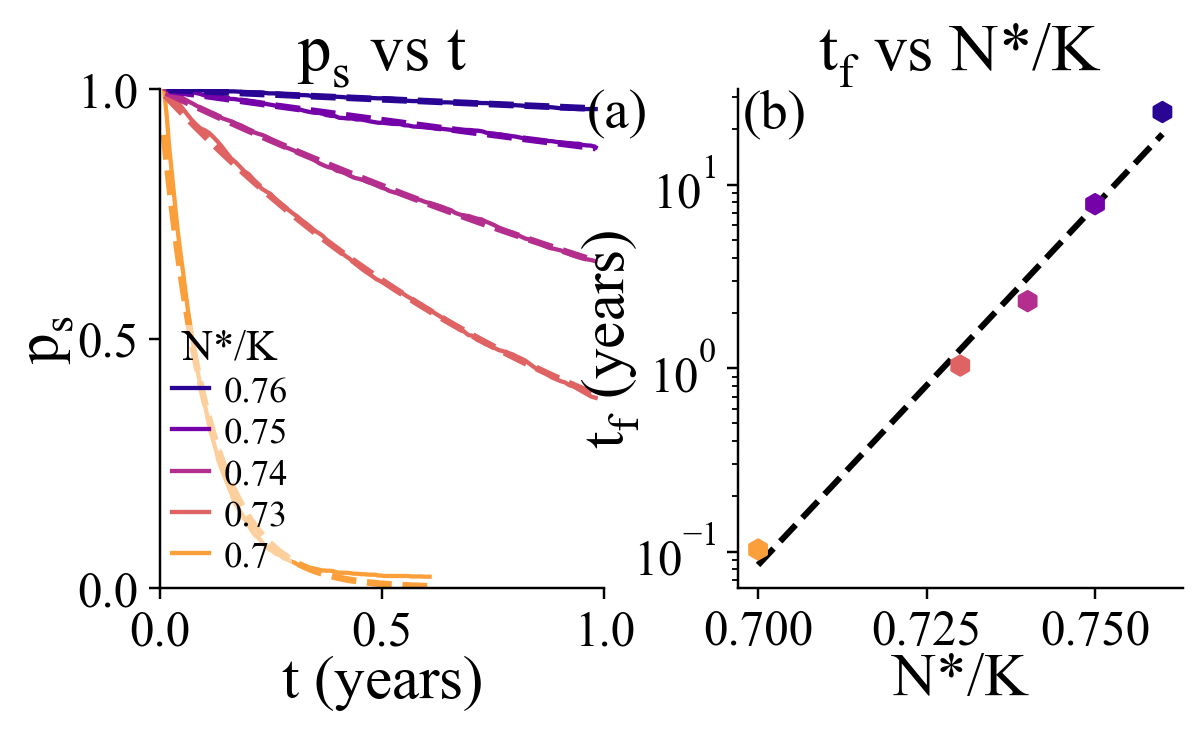

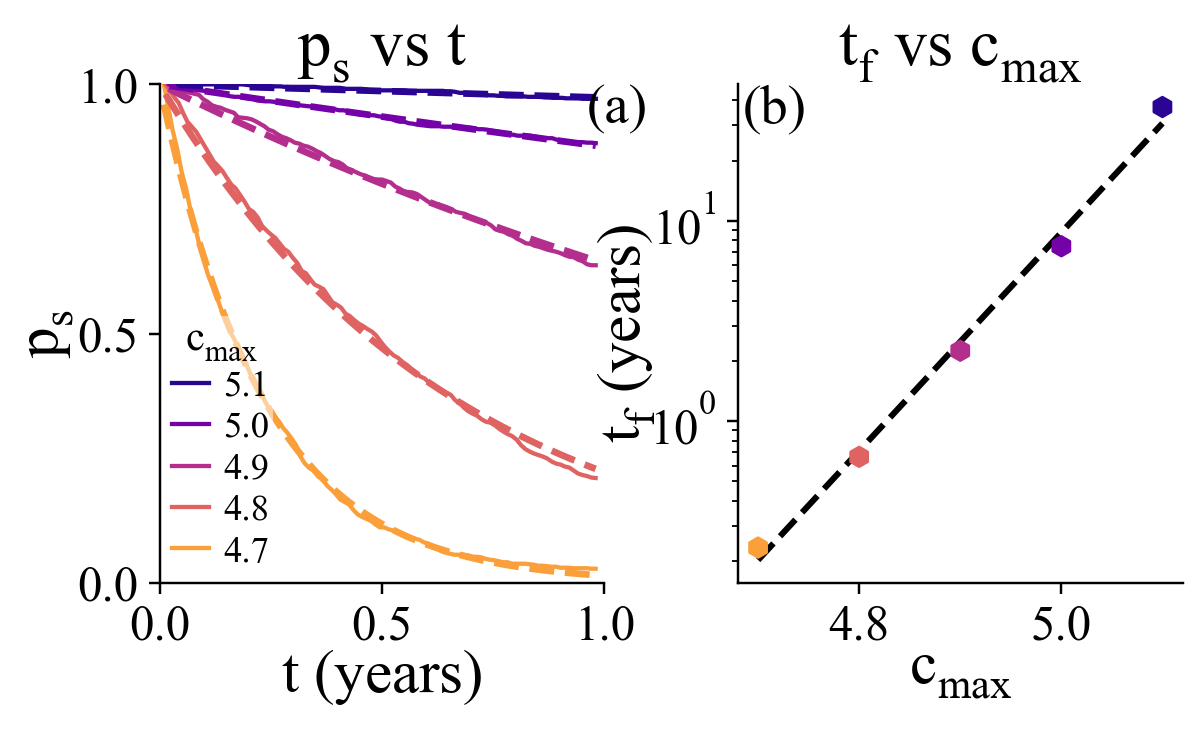

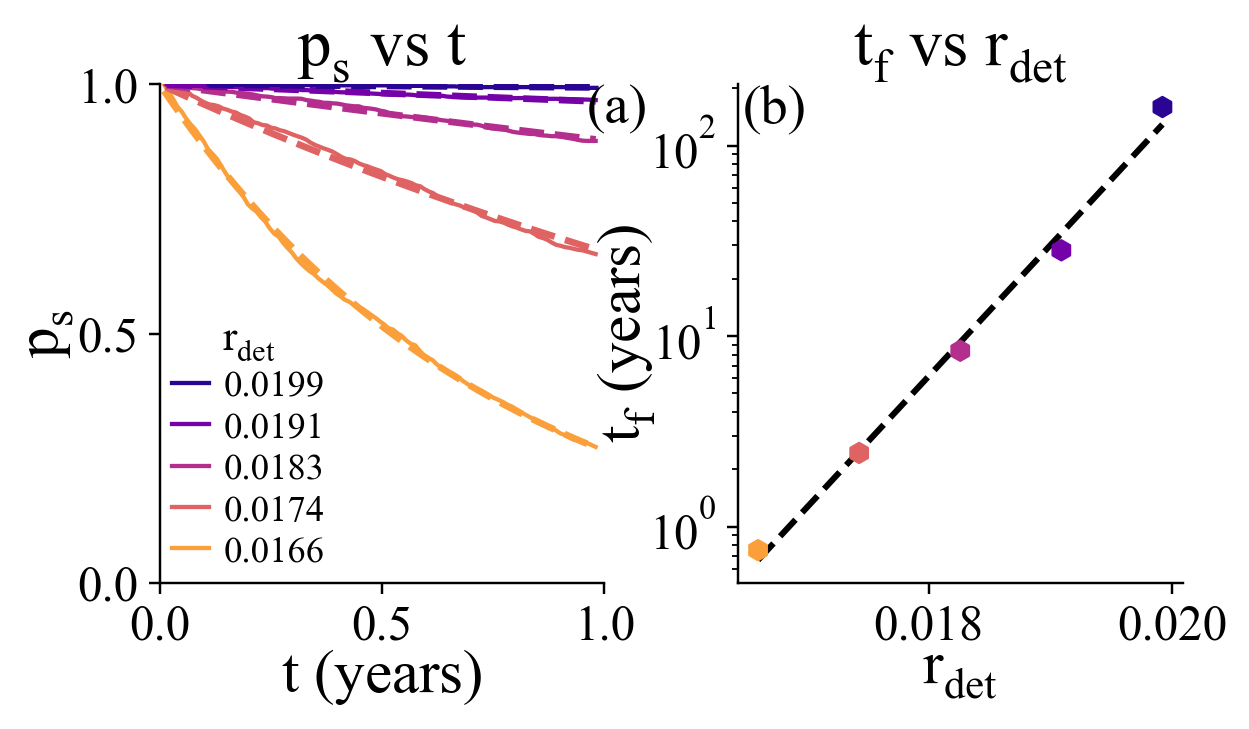

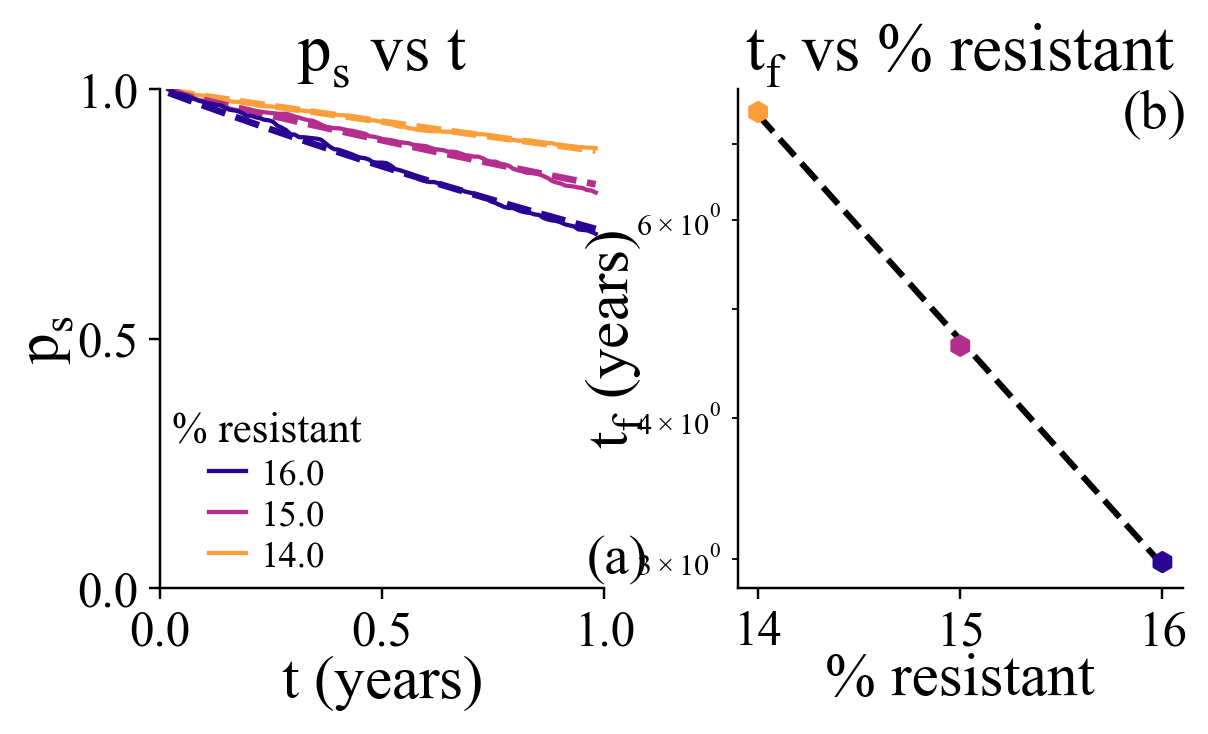

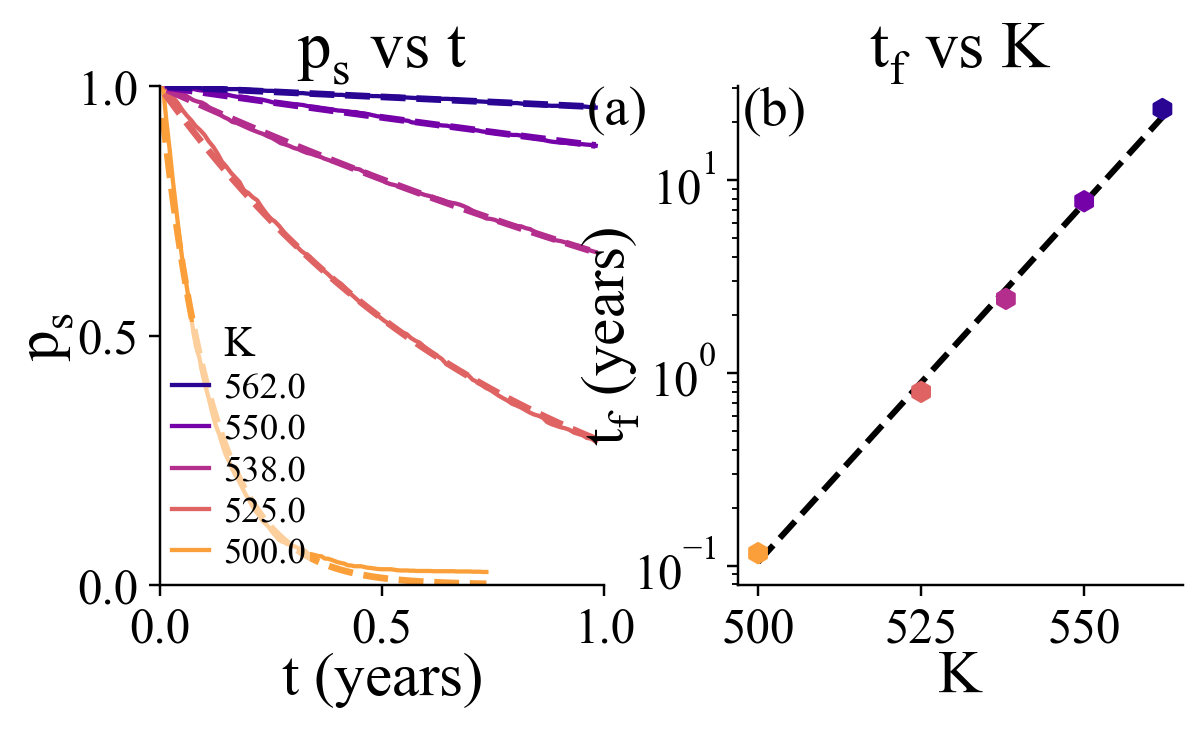

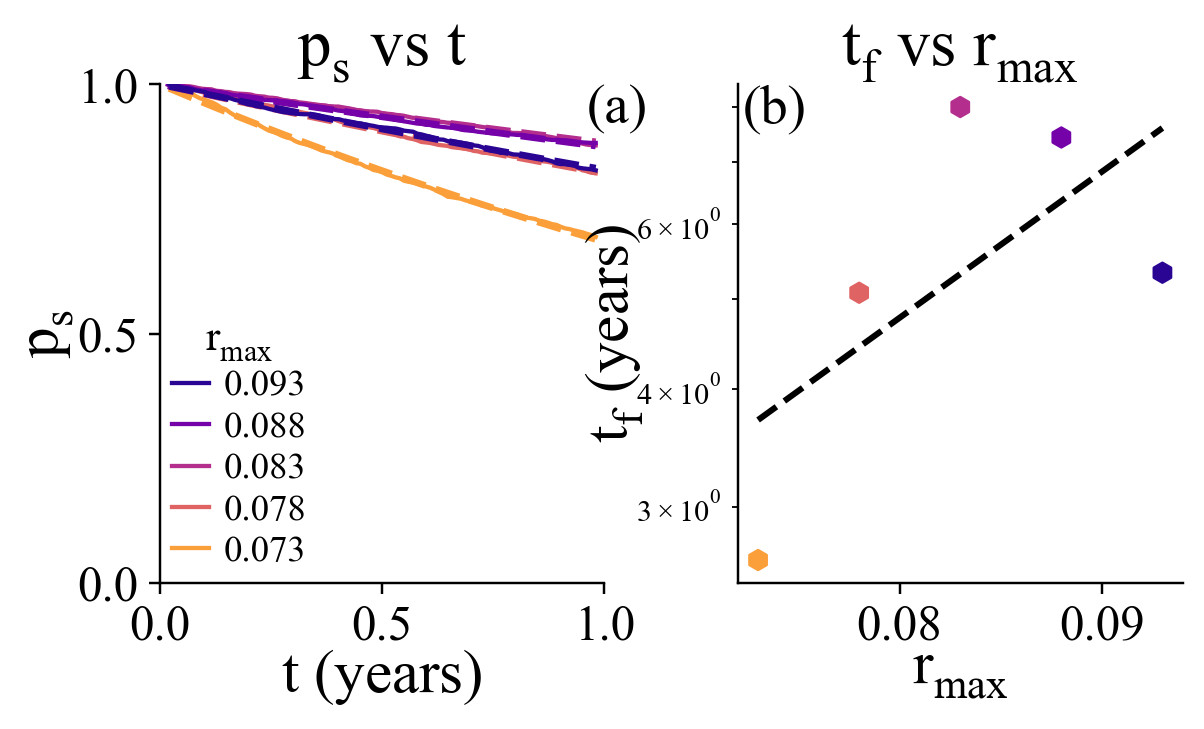

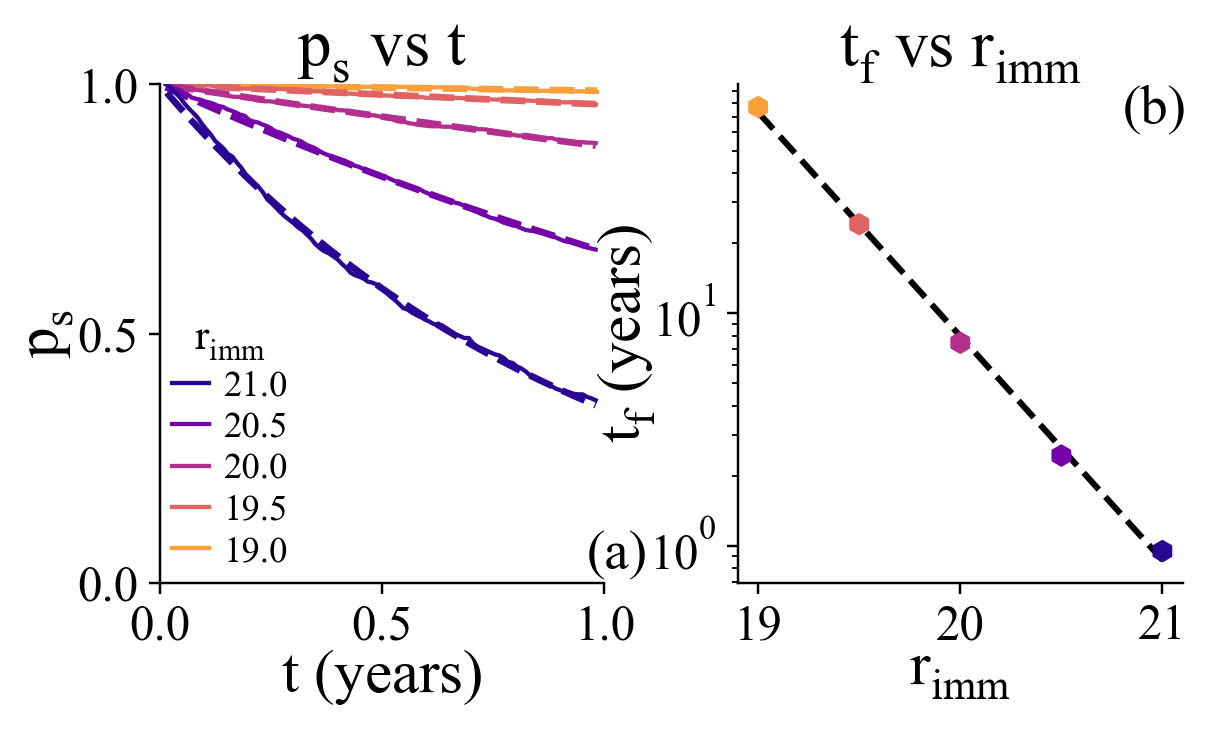

In [14]:
# ttf_15pc_cmax = plot_fitSlopes_and_failRate(ttf_15pcres_vs_cmax, cmax_vals, "$c_{\max}$", "ttf_plots_15pcres_vs_cmax")
# ttf_16pc_cmax = plot_fitSlopes_and_failRate(ttf_16pcres_vs_cmax, cmax_vals, "$c_{\max}$", "ttf_plots_16pcres_vs_cmax")
#print(ttf_14pc)
ttf_14pc_Nthresh    = plot_fitSlopes_and_failRate(ttf_14pcres_vs_N_thresh, N_thresh_vals,   "N$*/K$",      "ttf_plots_14pcres_vs_N_thresh", letter_in_top=True, n_sig_figs=3)
ttf_14pc_cmax       = plot_fitSlopes_and_failRate(ttf_14pcres_vs_cmax, cmax_vals,           "$c_{max}$",   "ttf_plots_14pcres_vs_cmax", units='ppm')
ttf_14pc_detRatio   = plot_fitSlopes_and_failRate(ttf_14pcres_vs_det_ratio, det_ratio_vals, "$r_{det}$",   "ttf_plots_det_ratio", letter_in_top=True, n_sig_figs=3, rescale=True, units='1/hour')
ttf_pc_res          = plot_fitSlopes_and_failRate(ttf_vs_pc_res, pc_res_vals,               "% resistant", "ttf_plots_pc_res", letter_in_top=False, n_sig_figs=3)
ttf_14pc_K          = plot_fitSlopes_and_failRate(ttf_14pcres_vs_K, K_vals,                 "$K$",         "ttf_plots_14pcres_vs_K", letter_in_top=True, n_sig_figs=4)
ttf_14pc_gMax       = plot_fitSlopes_and_failRate(ttf_14pcres_vs_g_max, g_max_vals,         "$r_{max}$",   "ttf_plots_14pcres_vs_gMax", letter_in_top=True, n_sig_figs=3, units='1/hour')
ttf_14pc_rImm       = plot_fitSlopes_and_failRate(ttf_14pcres_vs_rImm, rImm_vals,           "$r_{imm}$",   "ttf_plots_14pcres_vs_rImm", letter_in_top=False, n_sig_figs=3, units='1/hour')

# make a list of the ttf_vs_x_params
ttf_vs_x_list = [ttf_14pc_cmax, ttf_pc_res, ttf_14pc_rImm, ttf_14pc_detRatio, ttf_14pc_Nthresh, ttf_14pc_gMax]

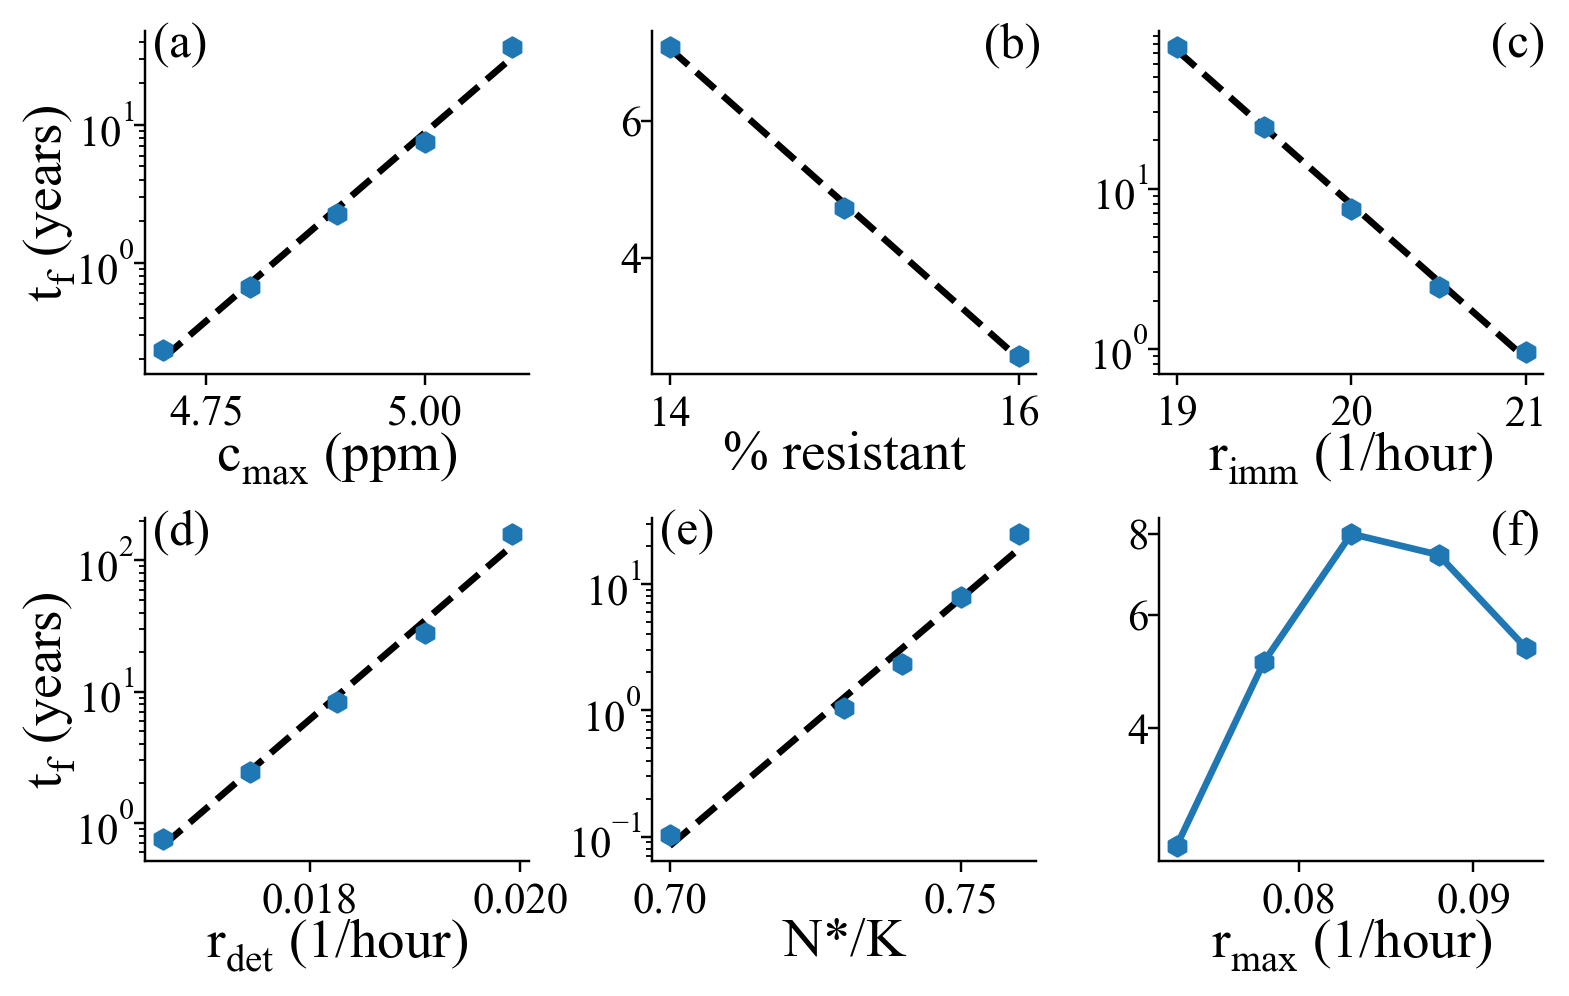

In [15]:
def plot_ttf_vs_x_param(ttf_vs_x_param_list):
    '''
    This is used to plot a 2x3 plot of all the ttf vs param plots (the log scale ones, slope of p_s)
    '''
    
    fig, axes = plt.subplots(2, 3, dpi=220)
    fig.set_size_inches(8.2,5)
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.42, wspace=0.32)
    titleSize = 12
    labelSize = 18
    numbersize = 14
    legendsize = 10
    IDsize=12
    nbins = 32
    lettersize = 16
    
    letters = list(string.ascii_lowercase)[:len(ttf_vs_x_param_list)]
    
    
    i = 0
    for ax, ttf_tuple, letter in zip(axes.flatten(), ttf_vs_x_param_list, letters):
        
        var_x_vals, ttf_y_vals, var_label, units = ttf_tuple
        
        
        # use this line for the old plotting style
        #ax.plot(var_x_vals, ttf_y_vals, marker='h', ms=6, lw=2.2)
        
        
        if any(var_label in s for s in ["$r_{max}$"]):

            ax.plot(var_x_vals, ttf_y_vals, lw=2.2, zorder=-20)
            ax.scatter(var_x_vals, ttf_y_vals, marker='h', s=40)
            
        else:
            p = np.array(np.polyfit(var_x_vals, np.log(ttf_y_vals), 1))
            ax.plot(np.array(var_x_vals), np.exp(p[0] * np.array(var_x_vals) + p[1]), 'k--', lw=2.2, zorder=-20)

            ax.scatter(var_x_vals, ttf_y_vals, marker='h', s=40)
        
        
        #ax.set_title('$t_s$ vs '+var_label, fontsize=titleSize)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        x_label_string = var_label+f" ({units})" if units else var_label
        ax.set_xlabel(x_label_string, fontsize=labelSize, labelpad=-1.4)
        if not i%(len(ttf_vs_x_param_list)//2): ax.set_ylabel('$t_f$ (years)', fontsize=labelSize, labelpad=-1) # label outer 
        
        letter_x = 0.02 if any(var_label in s for s in ["$c_{max}$", "$g_{max}$", "$r_{det}$", "N$*/K$"]) else 0.865
        
        ax.text(letter_x, 0.925, f"({letter})", transform=ax.transAxes, fontsize=lettersize)
        
        ax.xaxis.set_tick_params(labelsize=numbersize)
        ax.yaxis.set_tick_params(labelsize=numbersize, pad=0)
        ax.semilogy()
        
        if any(var_label in s for s in ["% resistant", "$r_{max}$"]):
            # ax.xaxis.set_major_locator(ticker.AutoLocator())
            #ax.xaxis.set_minor_locator(ticker.NullLocator())  # no minor ticks
            #ax.xaxis.set_major_formatter(ticker.ScalarFormatter())  # set regular formatting

            ax.yaxis.set_major_locator(ticker.AutoLocator())  # major y tick positions in a regular way
            #ax.yaxis.set_major_locator(ticker.MultipleLocator(2))  # major y tick positions every 2

            ax.yaxis.set_minor_locator(ticker.NullLocator())  # no minor ticks
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  # set regular formatting

            ax.ticklabel_format(style='sci', scilimits=(-1, 1), axis='y')  # disable scientific notation
        
        i = i+1
        
        
        
    plt.savefig('ms_paper_plots/surv_time_vs_model_param.pdf', bbox_inches='tight', dpi=320)
    plt.show()
    
plot_ttf_vs_x_param(ttf_vs_x_param_list=ttf_vs_x_list)

low r:  4.823  +/-  0.0053
high r: 5.776  +/-  0.0098
255550
n unique: 0.30284875758168656


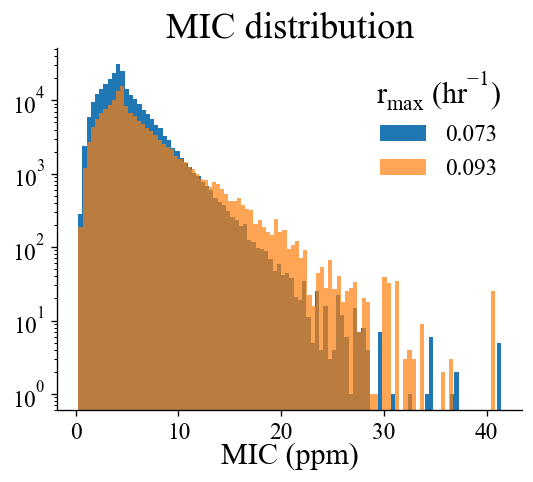

In [37]:
tmax = 24*365 # the max ttf sim time

df_low_gRate = pd.read_csv("time_to_failure_vs_g_max-EXTRA/timeToFailure-14_pc_res-g_max=0.073-final_pops.csv")
df_low_gRate = df_low_gRate[df_low_gRate["failure_time"]< (tmax-1)].filter(regex="geno_") # extract all the runs that established a biofilm, filter for the genotype columns

df_high_gRate = pd.read_csv("time_to_failure_vs_g_max-EXTRA/timeToFailure-14_pc_res-g_max=0.093-final_pops.csv")
df_high_gRate = df_high_gRate[df_high_gRate["failure_time"]< (tmax-1)].filter(regex="geno_")



print(f"low r:  {df_low_gRate.stack().dropna().mean():.3f}", " +/- ", f"{df_low_gRate.stack().std()/np.sqrt(df_low_gRate.stack().values.size):.4f}") # mean should ignore 
print(f"high r: {df_high_gRate.stack().dropna().mean():.3f}", " +/- ", f"{df_high_gRate.stack().std()/np.sqrt(df_high_gRate.stack().values.size):.4f}")
#print(pd.DataFrame.quantile(df_low_gRate.stack()))

#df_low_gRate.stack().values.mean()
df_low_gRate.stack().quantile([0.25, 0.5, 0.75])

print(df_low_gRate.stack().dropna().size)
print("n unique:", df_low_gRate.stack().nunique()/df_low_gRate.stack().size)



fig, ax = plt.subplots(1, 1, dpi=120)
fig.set_size_inches(5,4)
# for ax in axes:

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.hist(df_low_gRate.stack().values, bins=100, label="0.073", density=False)
ax.hist(df_high_gRate.stack().values, bins=100, label="0.093", density=False, alpha=0.7)
ax.legend(title="$r_{max}$ (hr$^{-1}$)", fontsize="14", frameon=False, title_fontsize=18)
ax.set_xlabel("MIC (ppm)", fontsize=18, labelpad=-1)
ax.semilogy()
ax.set_title('MIC distribution', fontsize=22)
ax.tick_params(axis='both', labelsize=14)
# axes[1].semilogx()
plt.savefig('geno_distb_plots/supp_geno_distb.jpg', dpi=300)
plt.savefig('geno_distb_plots/supp_geno_distb.pdf', bbox_inches='tight', dpi=330)
plt.show()

In [17]:
# # df_high_gRate = pd.read_csv("time_to_failure_vs_g_max-EXTRA/timeToFailure-14_pc_res-g_max=0.093-final_pops.csv")

# # df_high_gRate = df_high_gRate[df_high_gRate["failure_time"]< (tmax-1)].filter(regex="geno_")

# #print(df_high_gRate.mean().mean(), " +/- ", df_high_gRate.std().std())
# print(f"{df_high_gRate.stack().mean():.3f}", " +/- ", f"{df_high_gRate.stack().std()/np.sqrt(df_high_gRate.stack().values.size):.3f}")

# print(df_high_gRate.stack().dropna().size)
# print("n unique:", df_high_gRate.stack().nunique()/df_high_gRate.stack().size)

# df_high_gRate.stack().quantile([0.25, 0.5, 0.75])

# plt.hist(df_high_gRate.stack().values, bins=100)
# plt.show()

In [18]:
# def calc_shannon_equitability(geno_vals:np.array):
    
#     #geno_vals = np.random.choice(geno_vals[~np.isnan(geno_vals)], 129000)
#     geno_vals = geno_vals[~np.isnan(geno_vals)]
#     n_tot = geno_vals.size # no. of bacteria in the system
    
#     geno_vals_unique, geno_counts_unique = np.unique(geno_vals, return_counts=True) # get the number of times each unique species appears in the population
    
#     S = geno_counts_unique.size # no. of unique species in the system
        
# #     shannon_H = 0 # shannon index
# #     for i in range(geno_counts_unique.size):
# #         shannon_H += -(geno_counts_unique[i]/n_tot)*np.log(geno_counts_unique[i]/n_tot) # no. of each species / total population size
    
#     shannon_H = np.sum( -(geno_counts_unique/n_tot) * np.log((geno_counts_unique/n_tot)) )
        
#     shannon_E = shannon_H/np.log(S) # shannon equitability
    
#     print("H:",shannon_H)
#     print("E:",shannon_E,"\n")
        
    
        
   
    
# calc_shannon_equitability(df_low_gRate.stack().values)
# calc_shannon_equitability(df_high_gRate.stack().values)

## This section is a kinda hacky way to have a third subplot containing a histogram of the ttfs.  It's pretty hardcoded in its nature because I couldn't be bothered rewriting the above methods to do it nicely.

In [19]:
def survival_probability_v2(ttf_data, var_val, ax):
    '''takes in a dataframe and works out the survival probability as a function of time'''
    histo, bin_edges = np.histogram(ttf_data["failure_time"], bins=100)
    #print(histo)
    n_vals = len(ttf_data) #get number of runs
    survival_probs = (n_vals-np.cumsum(histo[1:]))/n_vals #get the survival probs (ignoring the 0 bin)
    survival_probs = np.append(1., survival_probs) #add the initial value of 1. for t = 0
    errs = (survival_probs*(1. - survival_probs))/np.sqrt(n_vals)
    #print(n_vals)
    #print(errs)
    #ignore the final value in surv_probs due to exit time being t_max by default
    if math.isclose(var_val, 4.7):
        
        titleSize = 22
        labelSize = 20
        numbersize = 16
        legendsize = 16
        IDsize=14
        letterSize=20
        nbins = 32
        
        t_scaled = np.array([t_val/(24.*365.) for t_val in bin_edges[:-2]])
#         print(survival_probs)
#         print(t_scaled)
        
        weights = np.ones_like(ttf_data["failure_time"])/float(len(ttf_data["failure_time"]))
        #ax.hist(ttf_data["failure_time"]/(24.*365.), bins=50, color='#005ce6', edgecolor='black', linewidth=0.2)
        #ax.hist(survival_probs)
        
        width = t_scaled[1] - t_scaled[0]
        
        ax.bar(t_scaled, survival_probs[:-1], width=width)
        ax.tick_params(axis='both', labelsize=numbersize)
        ax.set_xlabel('$t$ (years)', fontsize=labelSize, labelpad=-1)
        ax.set_ylabel('fraction of runs\nwithout biofilm', fontsize=labelSize, labelpad=-1)
        ax.text(0.84, 0.925, "(a)", transform=ax.transAxes, fontsize=letterSize)
        #ax.set_title('$S$ vs $t$ $(c_{max} = $  '+str(var_val)+')', fontsize=titleSize-1)
        ax.set_xlim(0, 1.0)
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_locator(plt.MaxNLocator(2))
    
    return bin_edges[:-2], survival_probs[:-1], errs[:-1]

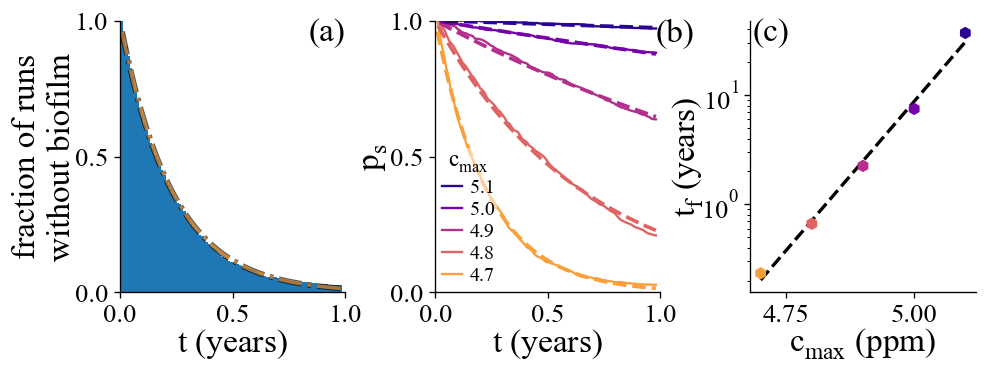

In [20]:
def plot_fitSlopes_and_failRate_v2(ttf_df_list, variable_vals, variable_name, filename, letter_in_top=True, n_sig_figs=2, rescale=False, units='ppm'):
    '''
    plots a 2x1 plot of the fitted survival probabilities and the time to failure vs c_max
    
    rescale is to convert r_det/g_max to just r_det, by multiplying each r_det by g_max

    '''
    
    fig, axes = plt.subplots(1, 3, dpi=120)
    fig.set_size_inches(9.2,3)
    plt.subplots_adjust(wspace=0.4)
    titleSize = 22
    labelSize = 20
    numbersize = 16
    legendsize = 16
    IDsize=14
    letterSize=20
    nbins = 32
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[2].spines['right'].set_visible(False)
    axes[2].spines['top'].set_visible(False)
    
    if rescale: variable_vals = [v*max_g_rate for v in variable_vals]
    
    variable_tau_and_err = [] #this is the list that the variable (eg c_max or rImm) vals, exponential slopes and the associated fit error will be saved to
    
    # fit curves to the survival probability data
    ######################################
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        #return a*np.exp(-b*x) #+ c
        return np.exp(-b*x)
        #return a*x + b
        
    # remove the white part of the colourmap
    min_val, max_val = 0.22,0.95
    n = 256
    orig_cmap = plt.cm.plasma_r
    colors = orig_cmap(np.linspace(min_val, max_val, n))
    c_map = colours.LinearSegmentedColormap.from_list("mycmap", colors)
    line_colours = c_map(np.linspace(0, 1, len(variable_vals)))
        
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, var_val, line_colour in zip(ttf_df_list, variable_vals, line_colours):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability_v2(ttf, var_val, axes[0])
        t_scaled = np.array([t_val/(24.*365.) for t_val in t])
        
        popt, pcov = curve_fit(func, t_scaled[0:], surv_prob[0:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        fit_errs = np.sqrt(np.diag(pcov))
        
        variable_tau_and_err.append((var_val, popt[1], fit_errs[1]))
        
        color=line_colour
        axes[1].plot(t_scaled, surv_prob, color=color, lw=1.4, label=f"{float((var_val)):.{n_sig_figs}}")
        axes[1].plot(t_scaled, func(t_scaled, *popt), color=color, ls='--', lw=2.2)
        
        if math.isclose(var_val, 4.7): 
            # multiply func by the max value in the histogram (hard coded 47 here), so the fit approx lines up with the histogram
            alpha=0.66
            axes[0].plot(t_scaled, func(t_scaled, *popt), color=color, ls='-.', alpha=alpha, lw=2.2, path_effects=[pe.Stroke(linewidth=2.4+1, foreground='k', alpha=alpha), pe.Normal()])
        
    #axes[1].set_title('$p_s$ vs $t$', fontsize=titleSize)
    axes[1].set_xlabel('$t$ (years)', fontsize=labelSize, labelpad=-1)
    axes[1].set_ylabel('$p_s$', fontsize=labelSize, labelpad=0)
    axes[1].xaxis.set_tick_params(labelsize=numbersize)
    axes[1].yaxis.set_tick_params(labelsize=numbersize)
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[::-1], frameon=True, loc=(0.02,0.02), title=variable_name,
                   handletextpad=0.4, framealpha=0.5, fontsize=12, borderpad=0.1, handlelength=1, labelspacing=0.2, edgecolor='none')
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].yaxis.set_major_locator(plt.MaxNLocator(2))
    
    if letter_in_top: axes[1].text(0.98, 0.925, "(b)", transform=axes[1].transAxes, fontsize=letterSize)
    else: axes[1].text(0.96, 0.03, "(b)", transform=axes[1].transAxes, fontsize=letterSize) 
    
    
    
    
    
    var_val, tau, tau_err = zip(*variable_tau_and_err) #transposes the list to extract the slopes
    tau_err_percent = [t_e/t for t, t_e in zip(tau, tau_err)] #find percent error to better manage reciprocals
    
    tau_scaled = [1./(t*24.*365.) for t in tau] #converts from per hour to time in years
    tau_err_scaled = [t*t_e_percent for t, t_e_percent in zip(tau_scaled, tau_err_percent)]

    
    ttf = [1./tau_val for tau_val in tau]
    tau_err_analytic = [(abs(1./t)*t_err/(abs(t)))*(1./(24.*365)) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    tau_err_analytic_v2 = [(abs(1./t)*t_err/(abs(t))) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors    

    
    p = np.array(np.polyfit(var_val, np.log(ttf), 1))
    axes[2].plot(np.array(var_val), np.exp(p[0] * np.array(var_val) + p[1]), 'k--', lw=2., zorder=-20)
    axes[2].scatter(var_val, ttf, marker='h', s=40, color=line_colours)
    
    #axes[2].set_title('$t_f$ vs '+variable_name, fontsize=titleSize)
    axes[2].set_xlabel(variable_name+f" ({units})", fontsize=labelSize, labelpad=-1)
    axes[2].set_ylabel('$t_f$ (years)', fontsize=labelSize, labelpad=-3)
    axes[2].xaxis.set_tick_params(labelsize=numbersize)
    axes[2].yaxis.set_tick_params(labelsize=numbersize)
    axes[2].semilogy()
    
    if letter_in_top: axes[2].text(0.01, 0.925, "(c)", transform=axes[2].transAxes, fontsize=letterSize)
    else: axes[2].text(0.865, 0.925, "(c)", transform=axes[2].transAxes, fontsize=letterSize)
#     axes[1].tick_params(axis='both', which='major', pad=1)
    
#     plt.subplots_adjust(wspace=0.3)
#     plt.savefig("time_to_failure_plots/"+filename+".pdf", bbox_inches="tight")
#     if variable_name == "$c_{max}$": plt.savefig("ms_paper_plots/"+filename+".pdf", bbox_inches='tight', dpi=330)
    plt.savefig("ms_paper_plots/"+filename+".pdf", bbox_inches='tight', dpi=420)
        
    plt.show()
    
    
    
    
    
    return var_val, ttf, variable_name # return the parameter values of interest, times to failure vs the parameter of interest, x-label for param of interest

ttf_14pc_cmax       = plot_fitSlopes_and_failRate_v2(ttf_14pcres_vs_cmax, cmax_vals,           "$c_{max}$",   "ttf_plots_14pcres_vs_cmax_with_histogram")


In [21]:
x = [1, 2, 3]
y = [4, 5, 6]
df2 = pd.DataFrame({'x':x, 'y':y})

df2

,x,y
0,1,4
1,2,5
2,3,6


82


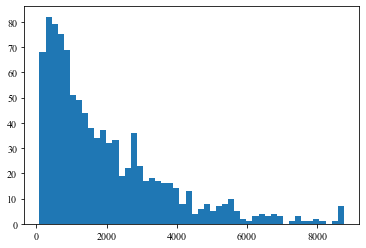

In [22]:
def survival_probability_v3(ttf_data):
    '''takes in a dataframe and works out the survival probability as a function of time'''
    histo, bin_edges = np.histogram(ttf_data["failure_time"], bins=50)
    n_vals = len(ttf_data) #get number of runs
    survival_probs = (n_vals-np.cumsum(histo[1:]))/n_vals #get the survival probs (ignoring the 0 bin)
    survival_probs = np.append(1., survival_probs) #add the initial value of 1. for t = 0
    errs = (survival_probs*(1. - survival_probs))/np.sqrt(n_vals)
    #print(n_vals)
    #print(errs)
    #ignore the final value in surv_probs due to exit time being t_max by default
    #if math.isclose(var_val, 4.8):
    print(np.max(histo))
    plt.hist(ttf_data["failure_time"], bins=50)
    
    #return bin_edges[:-2], survival_probs[:-1], errs[:-1]

survival_probability_v3(ttf_14pcres_vs_cmax[0])